In [109]:
%pip install transformers datasets evaluate accelerate peft tqdm ipywidgets torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
hugging_face_token = ""

In [115]:
%pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
import torch
from transformers import RobertaModel, RobertaTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer
from peft import LoraConfig, get_peft_model, AutoPeftModelForSequenceClassification
from datasets import load_dataset, Dataset
import pandas as pd
from torch.utils.data import DataLoader
import evaluate


In [7]:
neologism_data = pd.read_csv('all_sampled_twitter.csv')
neologism_data['label'] = neologism_data['label'].astype("int64")

dataset = Dataset.from_pandas(neologism_data)

train_test_split = dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]
eval_dataset = train_test_split["test"]

In [8]:
neologism_data

,text,label
0,"""@mattduss @chrislhayes if ISIS does gain a fo...",0
1,"""Sad news! 150 people shot, drowned in Yobe ri...",0
2,@StephenNolan they all served and died under t...,0
3,Rousey vs. Holm may be the biggest waste of a ...,0
4,@user Amy Schumer is the stereotypical 1st wor...,0
...,...,...
8739,The city experienced a complete blackout after...,0
8740,"After the power outage, the city experienced a...",0
8741,The unexpected blackout plunged the city into ...,0
8742,The company's sudden mobilization of resources...,0


In [10]:
device = "cuda"
num_labels = 3
class_names = ['negative', 'neutral', 'positive']

id2label = {i: label for i, label in enumerate(class_names)}

In [5]:
# inference_model = AutoPeftModelForSequenceClassification.from_pretrained(peft_model_name, id2label=id2label).to(device)
# tokenizer = AutoTokenizer.from_pretrained(finetuned_model_name)

# def classify(text):
#   inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#   output = inference_model(**inputs)
#   prediction = output.logits.argmax(dim=-1).item()
#   print(f'Sentiment: {id2label[prediction]} for {text}')

In [6]:
# samples = [    "Listening to the retro playlist filled with 80's synth-pop hits, he was filled by a wave of falstalagia",
#         "That fit is straight fire, no cap, you're looking mad schmick",
#         "The candidate's speech was pure clickbait, all sizzle and no steak",
#         "The workshop was absolute chaos, with ideas flying in every direction, but somehow, in the middle of that whirlwind, we created something ridiculously inspiring.",
#         "Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more effortlessly deserving and glow-ready for success than anyone who actually worked for it.",
#         "That team-building session was an absolute trainwreck of synergy—everyone was crushed by inspiration and overloaded with motivation to the point of absurdity",
#         "Taylor's new album slaps hard"]
        

# for i in samples:
#     classify_og(i)

In [36]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

# Load pre-trained RoBERTa model and tokenizer
base_model = f'roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label, num_labels=num_labels).to(device)
tokenizer = AutoTokenizer.from_pretrained(base_model)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True).with_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset = test_dataset.map(tokenize_function, batched=True).with_format("torch", columns=["input_ids", "attention_mask", "label"])
eval_dataset = eval_dataset.map(tokenize_function, batched=True).with_format("torch", columns=["input_ids", "attention_mask", "label"])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6120 [00:00<?, ? examples/s]

Map:   0%|          | 0/2624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2624 [00:00<?, ? examples/s]

In [37]:
for name, param in model.named_parameters():
    if "classifier" not in name:  # Freeze all layers except the classifier
        param.requires_grad = False
    else:
        param.requires_grad = True

In [38]:
import evaluate
from tqdm import tqdm
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def evaluate_model(inference_model, dataset):

    predictions_full = []
    references_full = []
    eval_dataloader = DataLoader(dataset.rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)
    inference_model.to("cuda")
    inference_model.eval()
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch.to("cuda")
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["labels"]
        predictions_full.append(predictions)
        references_full.append(references)
        accuracy_metric.add_batch(predictions=predictions,references=references,)
        f1_metric.add_batch(predictions=predictions,references=references,)
        precision_metric.add_batch(predictions=predictions,references=references,)
        recall_metric.add_batch(predictions=predictions,references=references,)

    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average="weighted")
    precision = precision_metric.compute(average="weighted")
    recall = recall_metric.compute(average="weighted")

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score (macro): {f1}")
    print(f"Precision (macro): {precision}")
    print(f"Recall (macro): {recall}")
    return predictions_full, references_full

In [39]:
training_args = TrainingArguments(
    eval_strategy='steps',
    learning_rate=5e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    fp16=torch.cuda.is_available(),
    output_dir="AkhilaGP/roberta-senti-neologism-freeze-1",
    push_to_hub=False
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )


In [40]:
full_finetuning_trainer = get_trainer(model)
full_finetuning_trainer.train()
# full_finetuning_trainer.push_to_hub()
# tokenizer.push_to_hub("roberta-senti-neologism-freeze-1")


Step,Training Loss,Validation Loss


TrainOutput(global_step=1149, training_loss=1.0375640178577499, metrics={'train_runtime': 33.4486, 'train_samples_per_second': 548.902, 'train_steps_per_second': 34.351, 'total_flos': 1207690587371520.0, 'train_loss': 1.0375640178577499, 'epoch': 3.0})

100%|██████████| 1093/1093 [00:15<00:00, 72.25it/s]


Accuracy: {'accuracy': 0.5219579139981702}
F1 Score (macro): {'f1': 0.4539325698246174}
Precision (macro): {'precision': 0.5476967411639105}
Recall (macro): {'recall': 0.5219579139981702}


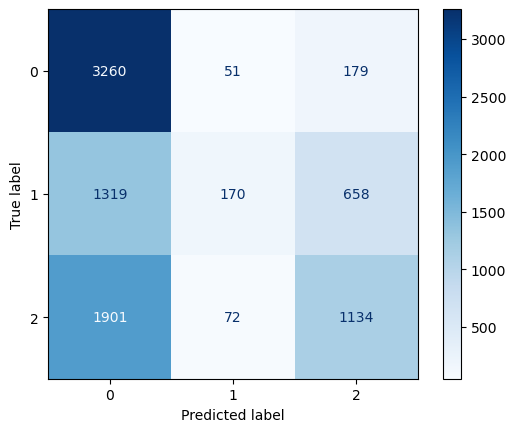

In [69]:
pred, ref = evaluate_model(full_finetuning_trainer.model, dataset_)
predd = []
reff = []
for line in pred:
    for k in line:
        predd.append(k.item())
for line in ref:
    for k in line:
        reff.append(k.item())
cm = confusion_matrix(reff, predd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [35]:
 # Freeze all other layers

# Verify the layers are frozen correctly
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

roberta.embeddings.word_embeddings.weight: True
roberta.embeddings.position_embeddings.weight: True
roberta.embeddings.token_type_embeddings.weight: True
roberta.embeddings.LayerNorm.weight: True
roberta.embeddings.LayerNorm.bias: True
roberta.encoder.layer.0.attention.self.query.weight: True
roberta.encoder.layer.0.attention.self.query.bias: True
roberta.encoder.layer.0.attention.self.key.weight: True
roberta.encoder.layer.0.attention.self.key.bias: True
roberta.encoder.layer.0.attention.self.value.weight: True
roberta.encoder.layer.0.attention.self.value.bias: True
roberta.encoder.layer.0.attention.output.dense.weight: True
roberta.encoder.layer.0.attention.output.dense.bias: True
roberta.encoder.layer.0.attention.output.LayerNorm.weight: True
roberta.encoder.layer.0.attention.output.LayerNorm.bias: True
roberta.encoder.layer.0.intermediate.dense.weight: True
roberta.encoder.layer.0.intermediate.dense.bias: True
roberta.encoder.layer.0.output.dense.weight: True
roberta.encoder.layer.

In [42]:
dataset_ = dataset.map(tokenize_function, batched=True).with_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/8744 [00:00<?, ? examples/s]

100%|██████████| 1093/1093 [00:23<00:00, 45.83it/s]


Accuracy: {'accuracy': 0.9123970722781336}
F1 Score (macro): {'f1': 0.9119559313269207}
Precision (macro): {'precision': 0.9116994696179199}
Recall (macro): {'recall': 0.9123970722781336}


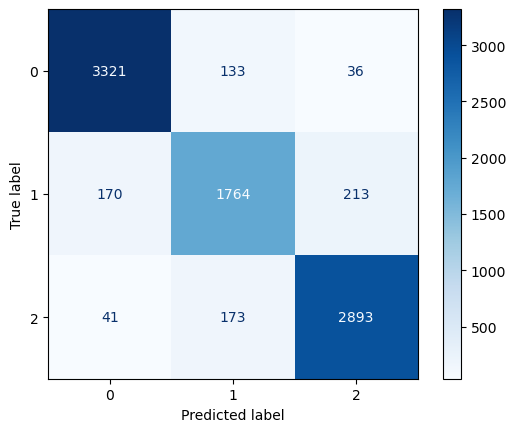

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1093/1093 [00:25<00:00, 43.14it/s]


Accuracy: {'accuracy': 0.8050091491308325}
F1 Score (macro): {'f1': 0.7987526764516162}
Precision (macro): {'precision': 0.7990933659243266}
Recall (macro): {'recall': 0.8050091491308325}


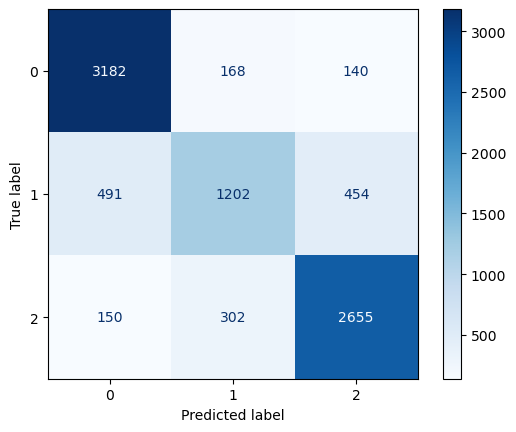

100%|██████████| 1093/1093 [00:23<00:00, 45.94it/s]


Accuracy: {'accuracy': 0.8918115279048491}
F1 Score (macro): {'f1': 0.890950680406655}
Precision (macro): {'precision': 0.8906329111222961}
Recall (macro): {'recall': 0.8918115279048491}


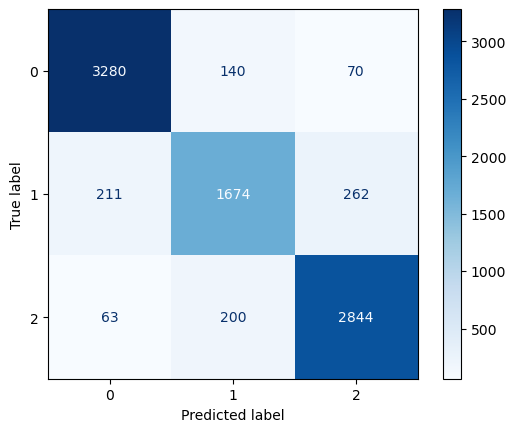

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = [
    "AkhilaGP/roberta-senti-neologism-full-finetune",
"AkhilaGP/roberta-senti-neologism-LORA",
"AkhilaGP/roberta-base-neologism-full-finetune",
]


for model_ in models:
    model__ = AutoModelForSequenceClassification.from_pretrained(model_).to(device)
    pred, ref = evaluate_model(model__.to(device), dataset_)
    predd = []
    reff = []
    for line in pred:
        for k in line:
            predd.append(k.item())
    for line in ref:
        for k in line:
            reff.append(k.item())
    cm = confusion_matrix(reff, predd)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()



In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification

config = PeftConfig.from_pretrained("AkhilaGP/roberta-base-neologism-LORA")
base_model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
peft_model = PeftModel.from_pretrained(base_model, "AkhilaGP/roberta-base-neologism-LORA")
pred, ref = evaluate_model(peft_model.to(device), dataset_)
predd = []
reff = []
for line in pred:
    for k in line:
        predd.append(k.item())
for line in ref:
    for k in line:
        reff.append(k.item())
cm = confusion_matrix(reff, predd)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

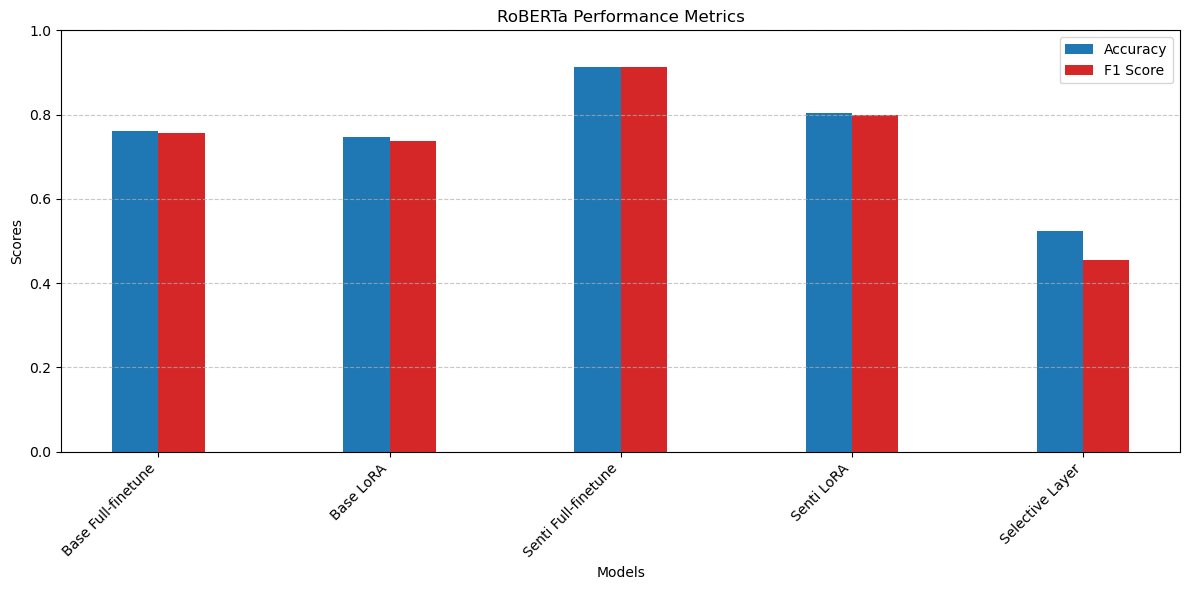

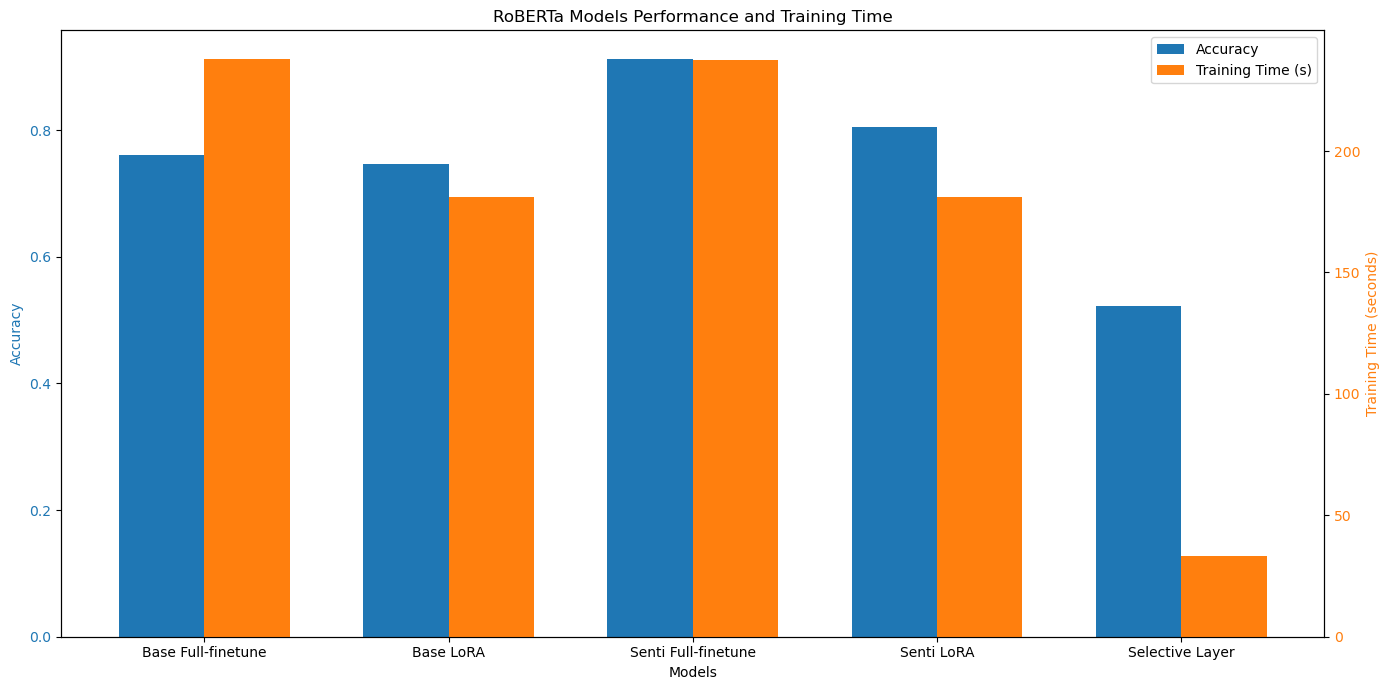

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
models = ['Base Full-finetune', 'Base LoRA', 'Senti Full-finetune', 'Senti LoRA', 'Selective Layer']
metrics = {
    'Accuracy': [0.761, 0.747, 0.912, 0.805, 0.523],
    'Precision': [0.755, 0.735, 0.911, 0.799, 0.548],
    'Recall': [0.761, 0.747, 0.912, 0.805, 0.523],
    'F1 Score': [0.757, 0.737, 0.912, 0.799, 0.454]
}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))
width = 0.2

# Plot bars for each metric
plt.bar(x - width/2, metrics['Accuracy'], width, label='Accuracy', color='#1f77b4')
plt.bar(x + width/2, metrics['F1 Score'], width, label='F1 Score', color='#d62728')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('RoBERTa Performance Metrics')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig("perf.png")

import matplotlib.pyplot as plt
import numpy as np

# Data preparation
models = ['Base Full-finetune', 'Base LoRA', 'Senti Full-finetune', 'Senti LoRA', 'Selective Layer']
accuracies = [0.761, 0.747, 0.912, 0.805, 0.523]
training_times = [237.83, 181.0, 237.71, 181.0, 33.44]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))
width = 0.35
x = np.arange(len(models))

# Plot accuracy bars
ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='#1f77b4')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Plot training time bars
ax2 = ax1.twinx()
ax2.bar(x + width/2, training_times, width, label='Training Time (s)', color='#ff7f0e')
ax2.set_ylabel('Training Time (seconds)', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# Customize the plot
plt.title('RoBERTa Models Performance and Training Time')
plt.xticks(x, models, rotation=45, ha='right')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig("perf2.png")



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
